In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np

In [ ]:
data_2017 = pd.read_csv('/content/drive/MyDrive/데마 팀플/기말 Project/DATA/prescription/CF_2017.csv')
#data_2021 = pd.read_csv('/content/drive/MyDrive/데마 팀플/기말 Project/DATA/prescription/CF_2021.csv')

In [ ]:
black_list_all = ['6453A', '6149A', '2422C', '4260C', '1391A', '4762A', '5232A', '5233A', '5234A', '1912A', '5055A', '3059A', '4952A', '2186A', '1149A', '2289A',
              '6349A', '6350A', '6351A', '6352A', '6396A', '5293A', '5294A', '4709A', '5042A',
              '6484A', '6485A', '6486A', '2222A', '3672A', '1790A', '1590A', '5293A', '4928A', '4685A'] #  '5242B', '5243B', '5267B', '6873B', '5244B', '5245B', '5246B', '6677B', '5204B' , '2013B'

In [ ]:
len(black_list_all)

35

In [ ]:
black_list_jw = [
              '6349A', '6350A', '6351A', '6352A', '6396A', '5293A', '5294A', '4709A', '5042A',
              '6484A', '6485A', '6486A', '2222A', '3672A', '1790A', '1590A', '5293A', '4928A', '4685A'] # , '5242B', '5243B', '5267B', '6873B', '5244B', '5245B', '5246B', '6677B', '5204B' , '2013B'

In [ ]:
data_2017.set_index('Unnamed: 0', inplace=True)
#data_2021.set_index('Unnamed: 0', inplace=True)

# 2017년도 리베이트 vs 모든약품 CF에서 0이 아닌 개수

In [ ]:
# Count non-zero values in each column
non_zero_counts_2017 = data_2017.ne(0).sum()
print(non_zero_counts_2017)
# Calculate the average of these non-zero counts
average_non_zero_2017 = non_zero_counts_2017.mean()
print(average_non_zero_2017)

1001A     38
1003A    644
1005A    235
1006A    463
1007A    942
        ... 
8006C      4
8009C     82
8010C     65
8011C     10
8012C    569
Length: 1612, dtype: int64
343.09181141439205


In [ ]:
# Filter to ensure the columns in black_list are in data_2017
filtered_columns_2017 = [col for col in black_list_all if col in data_2017.columns]

# Count zeros in each of the filtered columns
black_list_non_zero_2017 = data_2017[filtered_columns_2017].ne(0).sum()
print(black_list_non_zero_2017)
print(black_list_non_zero_2017.mean())

6453A     413
6149A    1060
2422C     215
4260C     118
1391A      74
4762A     608
5232A     346
5233A     227
5234A     149
1912A     167
5055A     726
3059A     537
4952A     214
2186A     324
1149A      99
2289A     428
6349A     149
6350A     316
6351A     115
6352A     214
6396A     463
5293A     389
5294A     121
4709A     893
5042A     643
6484A     306
6485A     383
6486A     286
2222A    1112
3672A    1123
1790A    1176
1590A     846
5293A     389
4928A     763
4685A     817
dtype: int64
463.1142857142857


In [ ]:
import scipy.stats as stats

# Sample data for both groups
group_1 = non_zero_counts_2017
group_2 = black_list_non_zero_2017

# Perform t-test
t_stat, p_value = stats.ttest_ind(group_2, group_1, equal_var=False)  # Welch's t-test for unequal variances

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# 중외제약 약품으로만 보면
# T-statistic: -2.2096192063232896
# P-value: 0.03937274391106949

T-statistic: 2.1329327108533596
P-value: 0.0399471376258028


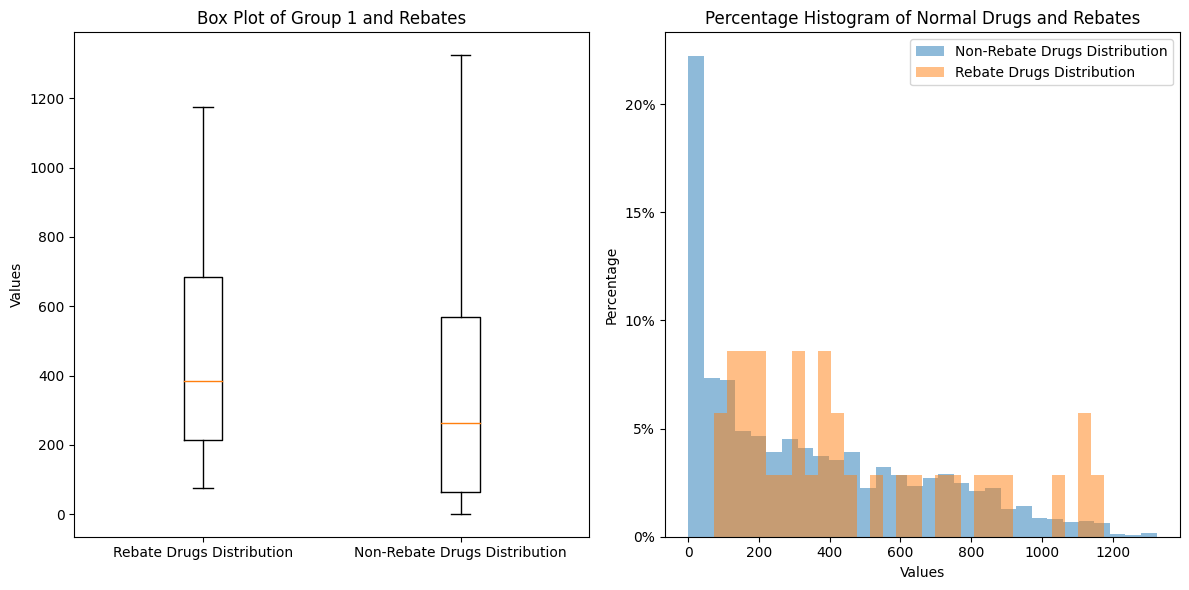

In [ ]:
import matplotlib.pyplot as plt

# 데이터 준비
group_1 = non_zero_counts_2017
group_2 = black_list_non_zero_2017

# 박스플롯 그리기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 그림
plt.boxplot([group_2, group_1], labels=['Rebate Drugs Distribution', 'Non-Rebate Drugs Distribution'])
plt.title('Box Plot of Group 1 and Rebates')
plt.ylabel('Values')

# 히스토그램 그리기
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 그림
# 각 데이터 포인트의 가중치 설정
weights1 = [1 / len(group_1) * 100] * len(group_1)
weights2 = [1 / len(group_2) * 100] * len(group_2)
plt.hist(group_1, bins=30, alpha=0.5, label='Non-Rebate Drugs Distribution', weights=weights1)
plt.hist(group_2, bins=30, alpha=0.5, label='Rebate Drugs Distribution', weights=weights2)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))  # Y축을 퍼센트로 표시
plt.title('Percentage Histogram of Normal Drugs and Rebates')
plt.xlabel('Values')
plt.ylabel('Percentage')
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


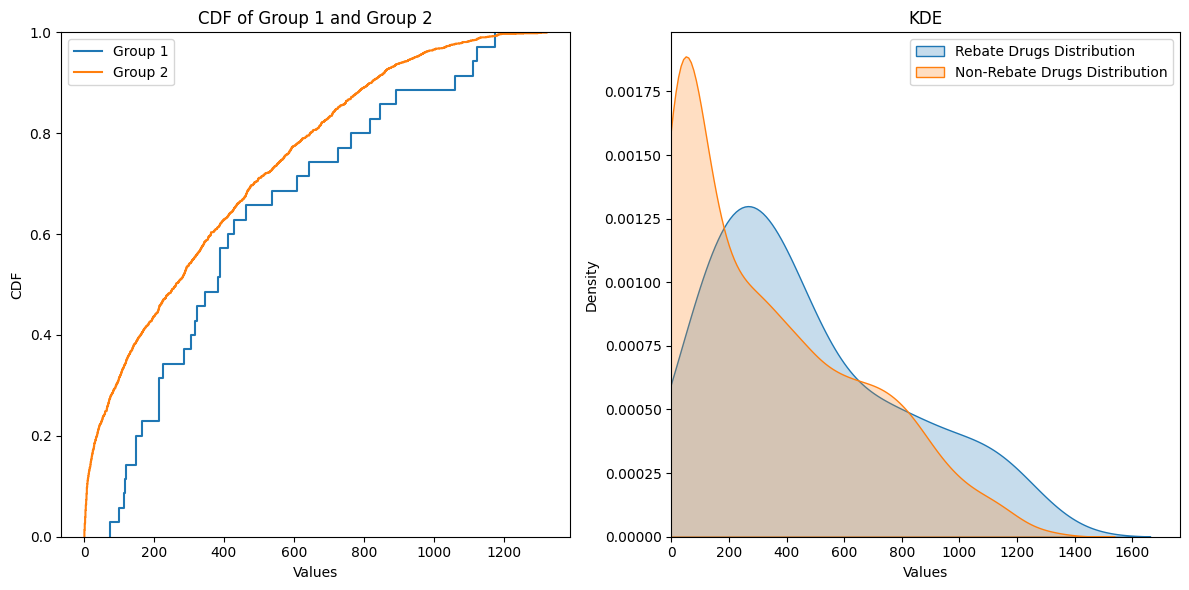

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 준비
group_2 = non_zero_counts_2017
group_1 = black_list_non_zero_2017

# 선형 그래프 그리기
plt.figure(figsize=(12, 6))

# CDF 그리기
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 그림
sns.ecdfplot(group_1, label='Group 1')
sns.ecdfplot(group_2, label='Group 2')
plt.title('CDF of Group 1 and Group 2')
plt.xlabel('Values')
plt.ylabel('CDF')
plt.legend()

# KDE 그리기
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 그림
sns.kdeplot(group_1, label='Rebate Drugs Distribution', fill=True)
sns.kdeplot(group_2, label='Non-Rebate Drugs Distribution', fill=True)
plt.title('KDE')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, None)  # x축 범위를 0부터 설정

# 그래프 표시
plt.tight_layout()
plt.show()


## CF값 0.01미만인 것들만 count해서 비교

In [ ]:
import scipy.stats as stats

data_2017_ver2 = data_2017.applymap(lambda x: 0 if x >= 0.01 else x)

non_zero_counts_2017_ver2 = data_2017_ver2.ne(0).sum()
average_non_zero_2017_ver2 = non_zero_counts_2017_ver2.mean()

# Filter to ensure the columns in black_list are in data_2017_ver2
filtered_columns_2017_ver2 = [col for col in black_list_all if col in data_2017_ver2.columns]

# Count zeros in each of the filtered columns
black_list_non_zero_2017_ver2 = data_2017_ver2[filtered_columns_2017_ver2].ne(0).sum()

# Sample data for both groups
group_1 = non_zero_counts_2017_ver2
group_2 = black_list_non_zero_2017_ver2

# Perform t-test
t_stat, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)  # Welch's t-test for unequal variances

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -2.2958871561303567
P-value: 0.027712992192278824


In [ ]:
group_1.mean()

428.34285714285716

In [ ]:
group_2.mean()

314.9441687344913

In [ ]:
group_1.to_csv('/content/drive/MyDrive/x1data_nonrebate.csv')
group_2.to_csv('/content/drive/MyDrive/x1data_rebate.csv')

In [ ]:
len(group_1)

1612

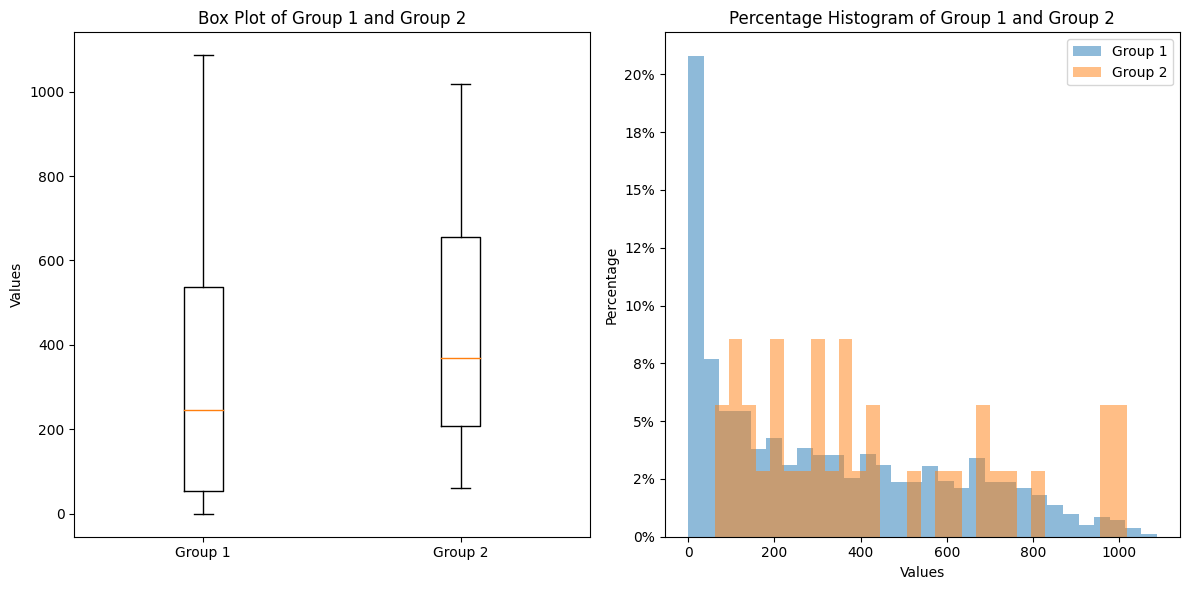

In [ ]:
# 데이터 준비
group_1 = non_zero_counts_2017_ver2
group_2 = black_list_non_zero_2017_ver2

# 박스플롯 그리기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 그림
plt.boxplot([group_1, group_2], labels=['Group 1', 'Group 2'])
plt.title('Box Plot of Group 1 and Group 2')
plt.ylabel('Values')

# 히스토그램 그리기
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 그림
# 각 데이터 포인트의 가중치 설정
weights1 = [1 / len(group_1) * 100] * len(group_1)
weights2 = [1 / len(group_2) * 100] * len(group_2)
plt.hist(group_1, bins=30, alpha=0.5, label='Group 1', weights=weights1)
plt.hist(group_2, bins=30, alpha=0.5, label='Group 2', weights=weights2)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))  # Y축을 퍼센트로 표시
plt.title('Percentage Histogram of Group 1 and Group 2')
plt.xlabel('Values')
plt.ylabel('Percentage')
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


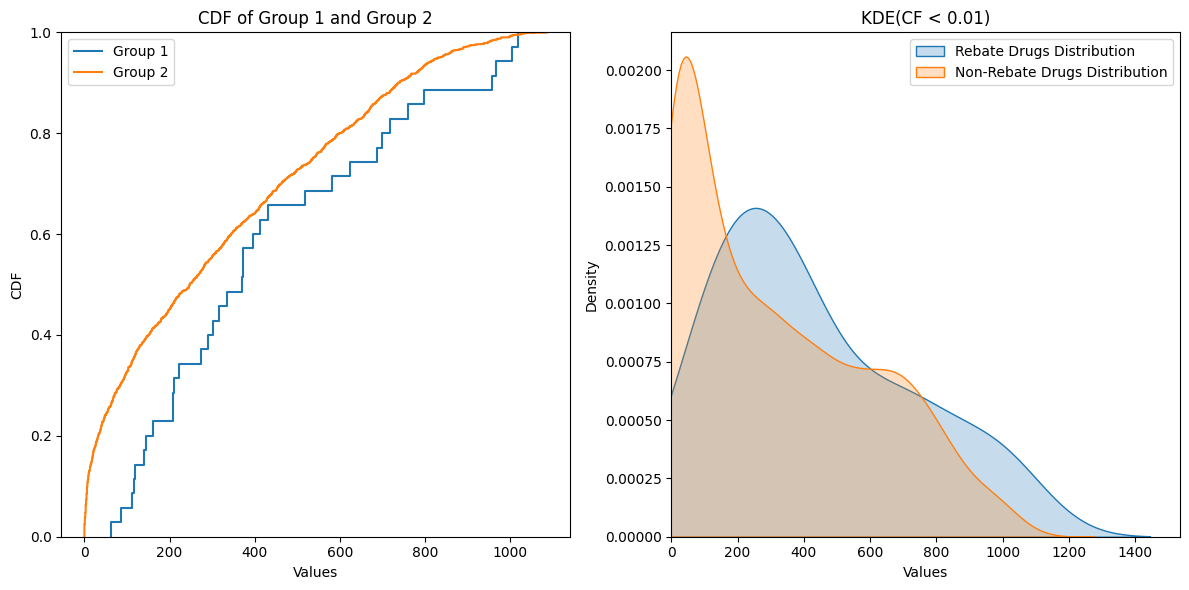

In [ ]:
group_2 = non_zero_counts_2017_ver2
group_1 = black_list_non_zero_2017_ver2

# 선형 그래프 그리기
plt.figure(figsize=(12, 6))

# CDF 그리기
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 그림
sns.ecdfplot(group_1, label='Group 1')
sns.ecdfplot(group_2, label='Group 2')
plt.title('CDF of Group 1 and Group 2')
plt.xlabel('Values')
plt.ylabel('CDF')
plt.legend()

# KDE 그리기
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 그림
sns.kdeplot(group_1, label='Rebate Drugs Distribution', fill=True)
sns.kdeplot(group_2, label='Non-Rebate Drugs Distribution', fill=True)
plt.title('KDE(CF < 0.01)')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, None)  # x축 범위를 0부터 설정

# 그래프 표시
plt.tight_layout()
plt.show()


# 2017 리베이트 약품들 vs 리베이트 약품과 동일한 성분들

In [ ]:
mapping = pd.read_csv('/content/drive/MyDrive/데마 팀플/기말 Project/DATA/건강보험심사평가원_제품코드_ATC.csv', encoding = 'cp949')

In [ ]:
filtered_rows = mapping[mapping['주성분(5)'].isin(black_list_all)]
sample = filtered_rows['식약분류'].unique()
filtered_rows = mapping[mapping['식약분류'].isin(sample)]
normal = filtered_rows['주성분(5)'].unique()
normal = np.array([item for item in normal if item not in black_list_all])

In [ ]:
# Filter to ensure the columns in normal are in data_2017
normal_columns_2017 = [col for col in normal if col in data_2017.columns]

# Count zeros in each of the filtered columns
normal_non_zero_2017 = data_2017[normal_columns_2017].ne(0).sum()
normal_non_zero_2017.mean()

412.5698729582577

In [ ]:
# Sample data for both groups
group_1 = normal_non_zero_2017
group_2 = black_list_non_zero_2017

# Perform t-test
t_stat, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)  # Welch's t-test for unequal variances

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -0.882303768599128
P-value: 0.3831642852099282


In [ ]:
normal_non_zero_2017

1009A    1079
1013A     856
1014A    1306
1107A     519
1423A    1129
         ... 
8009C      82
8010C      65
1908C     171
2162C     261
2461C     535
Length: 551, dtype: int64

In [ ]:
group_2

6453A     397
6149A     958
2422C     208
4260C     117
1391A      62
4762A     581
5232A     336
5233A     222
5234A     140
1912A     161
5055A     699
3059A     517
4952A     208
2186A     316
1149A      87
2289A     413
6349A     145
6350A     301
6351A     111
6352A     211
6396A     431
5293A     373
5294A     119
4709A     760
5042A     623
6484A     291
6485A     370
6486A     273
2222A     966
3672A    1004
1790A    1018
1590A     798
5293A     373
4928A     686
4685A     717
dtype: int64

## CF값 0.0001 미만인 것들만

In [ ]:
normal_non_zero_2017

1009A    1079
1013A     856
1014A    1306
1107A     519
1423A    1129
         ... 
8009C      82
8010C      65
1908C     171
2162C     261
2461C     535
Length: 551, dtype: int64

In [ ]:
data_2017_ver2 = data_2017.applymap(lambda x: 0 if x >= 0.0001 else x)

non_zero_counts_2017_ver2 = data_2017_ver2.ne(0).sum()
non_zero_counts_2017_ver2 = non_zero_counts_2017_ver2[normal_non_zero_2017.index]
non_zero_counts_2017_ver2

average_non_zero_2017_ver2 = non_zero_counts_2017_ver2.mean()

# Filter to ensure the columns in black_list are in data_2017_ver2
filtered_columns_2017_ver2 = [col for col in black_list_all if col in data_2017_ver2.columns]

# Count zeros in each of the filtered columns
black_list_non_zero_2017_ver2 = data_2017_ver2[filtered_columns_2017_ver2].ne(0).sum()

# Sample data for both groups
group_1 = non_zero_counts_2017_ver2
group_2 = black_list_non_zero_2017_ver2

# Perform t-test
t_stat, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)  # Welch's t-test for unequal variances

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 2.271861704871594
P-value: 0.026889599630254238
